In [1]:
import numpy as np
import glob
import sys
import os
%pylab inline --no-import-all


Populating the interactive namespace from numpy and matplotlib


In [2]:
from crispy.tools.initLogger import getLogger
log = getLogger('crispy')

In [3]:
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST660/')
from params import Params
par = Params()
par.hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                  2.0 / Interlacing                                    
PHILENS =    26.565051177077

# Create input cube with a simple gaussian PSF

In [4]:
from crispy.tools.imgtools import gausspsf
from crispy.tools.inputScene import input_star,bpgs_list
from astropy.io import fits
lamc=660.
BW=0.4
lamlist = np.arange(lamc*(1.-BW/2.),lamc*(1.+BW/2.)+5.,5)

inputCube = np.ones((len(lamlist), 512, 512), dtype=float)
inCube = fits.PrimaryHDU(inputCube)

# defines the sampling of your input cube (in terms of lambda/D at lam_c wavelength)
inCube.header['LAM_C'] = 0.66 # in microns
inCube.header['PIXSIZE'] = 0.1 # unit is lambda/D @lam_c

for i,lam in enumerate(lamlist):
    # replace this by your spatio-spectral scene of choice
    inCube.data[i] = gausspsf(size=512,fwhm=10*lam/lamc,offx=0.,offy=0.) # normalized gaussians

# Pick some input spectrum

           File       Name Type
13  bpgs_14.tab  THETA-VIR  A0V
19  bpgs_20.tab     58-AQL  A0V


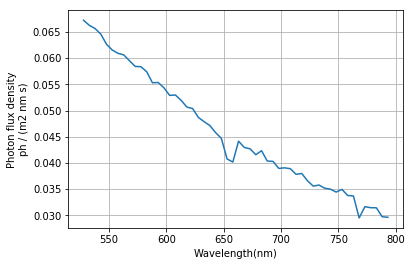

In [5]:
# looks through a pysynphot database of stars
spectral_type = 'A0V'
Vmag = 23
print(bpgs_list(spectral_type))
spectrum = input_star('../Inputs/bpgs/bpgs_14.fits',Vmag,lamlist)
plt.plot(lamlist,spectrum.value)
plt.xlabel('Wavelength(nm)')
plt.ylabel('Photon flux density\n{:}'.format(spectrum.unit))
plt.grid()

In [6]:
spec_nounits = spectrum.value
inCube.data *= spec_nounits[:,np.newaxis,np.newaxis]

In [7]:
inCube.writeto('/Users/mrizzo/Downloads/testinputcube.fits',overwrite=True)

Note that this cube still needs to be multiplied by the effective area function for the coronagraph.

# Propagate

In [8]:
from crispy.IFS import polychromeIFS
dlam = lamlist[1]-lamlist[0]
par.saveRotatedInput=True
# this integrates over wavelength and converts photons to electrons
# still need to multiply by some effective area ahead of time to get electrons per second
detectorFrame = polychromeIFS(
                            par,
                            lamlist,
                            inCube,
                            dlambda=dlam,
                            parallel=True,
                            lam_arr=lamlist)

print('..//SimResults/imagePlaneRot.fits is the input cube at the lenslet array')
print('..//SimResults/detectorFramepoly.fits is the wavelength-resolved detector cube')
print('..//SimResults/detectorFrame.fits is the detector image (the flattening of the cube)')

crispy - INFO - The number of input pixels per lenslet is 5.000000
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Creating Gaussian PSFLet templates
crispy - INFO - Writing data to ..//SimResults/imagePlaneRot.fits
crispy - INFO - Writing data to ..//SimResults/detectorFramepoly.fits
crispy - INFO - Writing data to ..//SimResults/detectorFrame.fits
crispy - INFO - Done.
crispy - INFO - Performance: 66 seconds total
..//SimResults/imagePlaneRot.fits is the input cube at the lenslet array
..//SimResults/detectorFramepoly.fits is the wavelength-resolved detector cube
..//SimResults/detectorFrame.fits is the detector image (the flattening of the cube)
